In [10]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# General imports
import os
import pickle
from scipy import stats
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from joblib import dump, load

# Utility imports
from utils.losses import *
from utils.plotting import *
from utils.training import *
from flows.flows import *

np.random.seed(666) # Need to do more to ensure data is the same across runs.
w = 3.5
h = 3.25              # Plots have dimension (w,h)

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Simple

## $A/B$ Parametrization

### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0    # bkgd: normal(-0.1, 1)     sgnl: normal(0.1, 1)
reps = 20

# File parameters
dirstr = 'models/univariate/simple/ab_mse/set_{}/'.format(num)
filestr = dirstr + 'model_{}_{}.h5'

if not os.path.isdir(dirstr):
    os.mkdir(dirstr)

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)
ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### MAEs

In [ ]:
avgs = np.load(dirstr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
plt.ylim(0, 1)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_simple.png', 
            dpi=300, 
            bbox_inches='tight')

### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0 
reps = 20

# Model parameters
dirstr = 'models/univariate/simple/ab_sqr/set_{}/'.format(num)
filestr_1 = dirstr + 'relu/model_{}_{}.h5'
filestr_2 = dirstr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### MAEs

In [ ]:
lin_avgs = np.load(dirstr + 'lin_avgs.npy')
exp_avgs = np.load(dirstr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_simple.png', 
            dpi=300, 
            bbox_inches='tight')

## Landscapes

### All

In [ ]:
rs = [0.1, 0.25, 0.5, 1]
fig, axs = plt.subplots(2, 4, sharex = True, sharey = True, figsize = (7, h - 0.15))

cplots = [[None] * 4] * 2

aa = np.load('anims/sqr/aa.npy')
bb = np.load('anims/sqr/bb.npy')

for i in range(len(rs)):
    r = rs[i]
    zz_loss = np.load('anims/sqr/zz_{}.npy'.format(r))
    zz_maes = np.load('anims/sqr_mae/normal/0/zz_{}.npy'.format(r))
    loss_contours = np.arange(1, 3.1, 0.025)
    maes_contours = np.arange(0, 7, 0.05)
    
    cplots[0][i] = axs[0][i].contourf(aa, bb, zz_loss, levels = 1000, cmap = 'plasma', vmin = 1.98, vmax = 2.25)
    axs[0][i].contour(aa, bb, zz_loss, levels = loss_contours, colors = 'white', linewidths = 0.75)
    axs[0][i].set_title(r'$r = {}$'.format(r), loc = 'right')
    axs[0][i].set_aspect('equal')
    
    cplots[1][i] = axs[1][i].contourf(aa, bb, zz_maes, levels = 1000, cmap = 'plasma', vmin = 0, vmax = 1)
    axs[1][i].contour(aa, bb, zz_maes, levels = maes_contours, colors = 'white', linewidths = 0.75)
    axs[1][i].set_aspect('equal')  

fig.tight_layout()
    
fig.colorbar(cplots[0][0], ax = [axs[0][0]], location = 'left')
fig.colorbar(cplots[0][3], ax = [axs[0][3]])

fig.colorbar(cplots[1][0], ax = [axs[1][0]], location = 'left')
fig.colorbar(cplots[1][3], ax = [axs[1][3]]);

plt.savefig('plots/paper/sqr_landscapes.png', 
            dpi=300, 
            bbox_inches='tight')

### Loss

In [ ]:
hh = 1.75

In [ ]:
dirstr = 'anims/sqr/'

aa = np.load(dirstr + 'aa.npy')
bb = np.load(dirstr + 'bb.npy')

contours = np.arange(1, 3.1, 0.02)

In [ ]:
r = 0.1

fig = plt.figure(figsize = (3, hh))
ax = fig.add_subplot(111)
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
img = ax.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 1.98, vmax = 2.25)
plt.colorbar(img, ax = [ax], pad = 0.18, location = 'left', ticks = np.arange(1.98, 2.02, 0.004))
ax.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)

ax.set_title(r'$r = {}$'.format(r), loc = 'right')
ax.set_xticklabels([])
ax.minorticks_on()
ax.tick_params(direction='in', which='both',length=5)
ax.set_ylabel(r'$b$')
ax.yaxis.set_label_coords(-.17, .5)

ax.set_aspect('equal')
plt.savefig('plots/paper/sqr_loss_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 0.25

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 1.98, vmax = 2.25)
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)
plt.title(r'$r = {}$'.format(r), loc = 'right')

plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_aspect('equal')
plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both',length=5)

plt.savefig('plots/paper/sqr_loss_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 0.5

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 1.98, vmax = 2.25)
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)
plt.title(r'$r = {}$'.format(r), loc = 'right')

plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_aspect('equal')
plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both',length=5)

plt.savefig('plots/paper/sqr_loss_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 1

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 1.98, vmax = 2.25)
plt.colorbar(ticks = np.arange(1.98, 2.7, 0.08))
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)
plt.title(r'$r = {}$'.format(r), loc = 'right')

plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_aspect('equal')
plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both',length=5)

plt.savefig('plots/paper/sqr_loss_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

### MAE

In [ ]:
dirstr = 'anims/sqr_mae/normal/0/'

aa = np.load(dirstr + 'aa.npy')
bb = np.load(dirstr + 'bb.npy')

contours = np.arange(0, 7, 0.05)

In [ ]:
r = 0.1

fig = plt.figure(figsize = (3, hh))
ax = fig.add_subplot(111)
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
img = ax.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 0, vmax = 1)
plt.colorbar(img, ax = [ax], pad = 0.18, location = 'left', ticks = np.arange(0.06, 0.28, 0.02))
ax.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)

ax.minorticks_on()
ax.tick_params(direction='in', which='both',length=5)
ax.set_ylabel(r'$b$')
ax.yaxis.set_label_coords(-.17, .5)
ax.set_xlabel(r'$a$')

ax.set_aspect('equal')
plt.savefig('plots/paper/sqr_maes_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 0.25

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 0, vmax = 1)
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)

plt.gca().set_yticklabels([])
plt.gca().set_aspect('equal')
plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both',length=5)
plt.gca().set_xlabel(r'$a$')

plt.savefig('plots/paper/sqr_maes_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 0.5

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 0, vmax = 1)
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)

plt.gca().set_yticklabels([])
plt.gca().set_aspect('equal')
plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both',length=5)
plt.gca().set_xlabel(r'$a$')

plt.savefig('plots/paper/sqr_maes_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 1

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 0, vmax = 1)
plt.colorbar(ticks = np.arange(0, 3.71, 0.42))
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)

plt.gca().set_yticklabels([])
plt.gca().set_aspect('equal')
plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both',length=5)
plt.gca().set_xlabel(r'$a$')

plt.savefig('plots/paper/sqr_maes_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

# Normal

## Naïve Implementation

In [ ]:
# Experiment parameters
num = 0
reps = 100
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':mlc, 'output':'relu'}
sqr_params = {'loss':sqr, 'output':'relu'}

filestr = 'models/univariate/loss_comp/set_{}/'.format(num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
mse_filestr = filestr + 'mse/model_{}_{}.h5'
mlc_filestr = filestr + 'mlc/model_{}_{}.h5'
sqr_filestr = filestr + 'sqr/model_{}_{}.h5'

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

### Likelihood Ratios

#### Process

#### Plot

In [ ]:
xs = np.load(filestr + 'xs.npy')
bce_preds = np.load(filestr + 'bce_preds.npy')
mse_preds = np.load(filestr + 'mse_preds.npy')
mlc_preds = np.load(filestr + 'mlc_preds.npy')
sqr_preds = np.load(filestr + 'sqr_preds.npy')

In [ ]:
ratio_plot([bce_preds, mse_preds, mlc_preds, sqr_preds],
           ['BCE', 'MSE', 'MLC', 'SQR'],
           lr,
           bkgd, sgnl,
           xs,
           figsize = (w, h),
           title = r'\it Na\"ive Implementation',
           filename = 'plots/paper/naive_fit.png')

### MAEs

#### Process

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
mse_avg = np.load(filestr + 'mse_avg.npy')
mlc_avg = np.load(filestr + 'mlc_avg.npy')
sqr_avg = np.load(filestr + 'sqr_avg.npy')

In [ ]:
mae_plot([bce_avg, mse_avg, mlc_avg, sqr_avg],
         ['BCE', 'MSE', 'MLC', 'SQR'],
         Ns,
         figsize = (w, h),
         title = r'\it Na\"ive Implementation',
         filename = 'plots/paper/naive_sizes.png')

## $C$ Parametrization

### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce}
params_2 = {'loss':tanh_bce, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'output': 'linear'}

filestr = 'models/univariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           figsize = (w, h),
           title = r'\it Parametrizing $f$',
           filename = 'plots/paper/c_bce.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':tanh_mse, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'output': 'linear'}

filestr = 'models/univariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           figsize = (w, h),
           title = r'\it Parametrizing $f$',
           filename = 'plots/paper/c_mse.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'output': 'linear'}

filestr = 'models/univariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           figsize = (w, h),
           title = r'\it Parametrizing $f$',
           filename = 'plots/paper/c_mlc.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'output': 'linear'}

filestr = 'models/univariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           figsize = (w, h),
           title = r'\it Parametrizing $f$',
           filename = 'plots/paper/c_sqr.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

## Generalized Loss Families

### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
plt.ylim(0, 0.16)

plt.title(r"\it $r$-SQR Losses",loc="right");
plt.savefig('plots/paper/ab_sqr.png', 
            dpi=300, 
            bbox_inches='tight')

### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
plt.ylim(0, 0.16)

plt.title(r"\it $p$-MSE Losses",loc="right");
plt.savefig('plots/paper/ab_mse.png', 
            dpi=300, 
            bbox_inches='tight')

## Optimized Implementation

In [ ]:
num = 3
reps = 100
Ns = 10**np.arange(2, 8)

mu = 0.1
bkgd = stats.norm(-mu, 1)
sgnl = stats.norm(mu, 1)

mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')
lr = make_lr(bkgd, sgnl)

# Model parameters
p = 1.24
r = 0.018
bce_params = {'loss':bce}
mse_params = {'loss':get_mse(p)}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':get_exp_sqr(r), 'output':'linear'}

filestr = 'models/univariate/loss_comp/set_{}/'.format(num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
mse_filestr = filestr + 'mse/model_{}_{}.h5'
mlc_filestr = filestr + 'mlc/model_{}_{}.h5'
sqr_filestr = filestr + 'sqr/model_{}_{}.h5'

### Likelihood Ratios

#### Process

#### Plot

In [ ]:
xs = np.load(filestr + 'xs.npy')
bce_preds = np.load(filestr + 'bce_preds.npy')
mse_preds = np.load(filestr + 'mse_preds.npy')
mlc_preds = np.load(filestr + 'mlc_preds.npy')
sqr_preds = np.load(filestr + 'sqr_preds.npy')

In [ ]:
ratio_plot([bce_preds, mse_preds, mlc_preds, sqr_preds],
           ['BCE', 'MSE', 'MLC', 'SQR'],
           lr,
           bkgd, sgnl,
           xs,
           figsize = (w, h),
           title = r'\it Optimized Implementation',
           filename = 'plots/paper/best_fit_3.png')

### MAEs

#### Process

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
mse_avg = np.load(filestr + 'mse_avg.npy')
mlc_avg = np.load(filestr + 'mlc_avg.npy')
sqr_avg = np.load(filestr + 'sqr_avg.npy')

In [ ]:
bce_avg[4], mse_avg[4], mlc_avg[4], sqr_avg[4]

In [ ]:
mae_plot([bce_avg, mse_avg, mlc_avg, sqr_avg],
         ['BCE', 'MSE', 'MLC', 'SQR'],
         Ns,
         figsize = (w, h),
         title = r'\it Optimized Implementation',
         filename = 'plots/paper/normal/best_sizes_3.png')

# Shifting Normals

## $A/B$ Parametrization

### $0.2$

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.2/X_trn.npy')[:N]
y = np.load('data/normal/0.2/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.2, 1)
sgnl = stats.norm(+0.2, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.2/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_0.2.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.2/X_trn.npy')[:N]
y = np.load('data/normal/0.2/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.2, 1)
sgnl = stats.norm(+0.2, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.2/')

##### Process

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_0.2.png', 
            dpi=300, 
            bbox_inches='tight')

### $0.3$

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.3/X_trn.npy')[:N]
y = np.load('data/normal/0.3/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.3, 1)
sgnl = stats.norm(+0.3, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.3/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_0.3.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.3/X_trn.npy')[:N]
y = np.load('data/normal/0.3/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.3, 1)
sgnl = stats.norm(+0.3, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.3/')

##### Process

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_0.3.png', 
            dpi=300, 
            bbox_inches='tight')

### $0.4$

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.4/X_trn.npy')[:N]
y = np.load('data/normal/0.4/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.4, 1)
sgnl = stats.norm(+0.4, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.4/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_0.4.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.4/X_trn.npy')[:N]
y = np.load('data/normal/0.4/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.4, 1)
sgnl = stats.norm(+0.4, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.4/')

##### Process

In [ ]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r, end = '\t')
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = pow_exp_lr(exp_model, r, m, s)
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.mean(lin_maes)]
    exp_avgs += [np.mean(exp_maes)]

In [ ]:
# Save results
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_0.4.png', 
            dpi=300, 
            bbox_inches='tight')

### $0.5$

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.5/X_trn.npy')[:N]
y = np.load('data/normal/0.5/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.5, 1)
sgnl = stats.norm(+0.5, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.5/')

##### Process

In [ ]:
# Get model likelihood ratios.
avgs = []
for p in ps:
    print(p, end = '\t')
    lrs = [None] * reps
    params = {'loss':get_mse(p)}
    for i in range(reps):
        model = create_model(**params)
        model.load_weights(mse_filestr.format(p, i))
        lrs[i] = pow_odds_lr(model, p, m, s)
    
    maes = [mae(lr) for lr in lrs]
    avgs += [np.mean(maes)]

avgs = np.array(avgs)

In [ ]:
# Save results
np.save(filestr + 'avgs', avgs)

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_0.5.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.5/X_trn.npy')[:N]
y = np.load('data/normal/0.5/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.5, 1)
sgnl = stats.norm(+0.5, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.5/')

##### Process

In [ ]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r, end = '\t')
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = pow_exp_lr(exp_model, r, m, s)
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.mean(lin_maes)]
    exp_avgs += [np.mean(exp_maes)]

In [ ]:
# Save results
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_0.5.png', 
            dpi=300, 
            bbox_inches='tight')

# Beta

## $C$ Parametrizations

### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce}
params_2 = {'loss':tanh_bce, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'output': 'linear'}

filestr = 'models/univariate/beta/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (8, 8),
           title = r'\it $C$ Parametrization')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':tanh_mse, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'output': 'linear'}

filestr = 'models/univariate/beta/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_mse_beta.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'output': 'linear'}

filestr = 'models/univariate/beta/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### Likelihood Ratio

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_mlc_beta.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'output': 'linear'}

filestr = 'models/univariate/beta/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_sqr_beta.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

## $A/B$ Parametrization

### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 5
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_beta.png', 
            dpi=300, 
            bbox_inches='tight')

### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 5
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_beta.png', 
            dpi=300, 
            bbox_inches='tight')

# Gamma

## $C$ Parametrizations

### BCE $C$ Parametrizations

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce}
params_2 = {'loss':tanh_bce, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
xs = np.linspace(0, 20, 1201)
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'xs.npy', xs)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_bce_gamma.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MSE $C$ Parametrizations

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':tanh_mse, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
xs = np.linspace(0, 20, 1201)
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'xs.npy', xs)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_mse_gamma.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MLC $C$ Parametrizations

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
xs = np.linspace(0, 20, 1201)
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'xs.npy', xs)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_mlc_gamma.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### SQR $C$ Parametrizations

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
xs = np.linspace(0, 20, 1201)
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'xs.npy', xs)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_sqr_gamma.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

## $A/B$ Parametrization

### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 6
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

#### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_gamma.png', 
            dpi=300, 
            bbox_inches='tight')

### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 6
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

#### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_gamma.png', 
            dpi=300, 
            bbox_inches='tight')

# Multivariate Normal

## Naïve Implementation

### Case 0

### Case 1

### Case 2

### Case 3

### Case 4

## $C$ Parametrization

In [ ]:
w = 3.5
h = 2.9

g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

### Case 0

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_vertical_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_vertical_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_vertical_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_vertical_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_vertical_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_vertical_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_vertical_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_vertical_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_vertical_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_vertical_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_vertical_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_vertical_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### Case 1

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_slant_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_slant_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_slant_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_slant_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_slant_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_slant_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_slant_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_slant_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_slant_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_slant_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_slant_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_slant_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### Case 2

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_circle_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_circle_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_circle_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_circle_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_circle_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_circle_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_circle_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_circle_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_circle_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_circle_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_circle_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_circle_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### Case 3

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_hyperbola_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_hyperbola_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_hyperbola_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mse_hyperbola_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mse_hyperbola_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mse_hyperbola_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_hyperbola_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_hyperbola_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_hyperbola_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_sqr_hyperbola_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_sqr_hyperbola_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_sqr_hyperbola_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### Case 4

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_bce_checker_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_bce_checker_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_bce_checker_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_checker_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_checker_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_checker_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mlc_checker_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mlc_checker_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mlc_checker_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_checker_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_checker_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_checker_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

## $A/B$ Parametrization

### Case 0

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_vertical.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_vertical.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 1

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_slant.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_slant.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 2

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_circle.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_circle.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 3

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_hyperbola.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_hyperbola.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 4

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_checker.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

In [ ]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r, end = '\t')
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'd': 2, 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'd': 2, 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = pow_exp_lr(exp_model, r, m, s)
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.mean(lin_maes)]
    exp_avgs += [np.mean(exp_maes)]

In [ ]:
# Save results
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_checker.png', 
            dpi=300, 
            bbox_inches='tight')

# Zenodo

# Trees

## Vertical

### $d = 1$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 1
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

In [ ]:
N = 10**6
X = np.load('data/trees/X_trn.npy')[:N]
y = np.load('data/trees/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# Load in models.
bce_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(N, i))
    bce_lrs[i] = odds_lr(bce_model, m, s)

xs = np.linspace(-6, 6, 1201)

bce_preds = get_preds(bce_lrs, xs)

# BDT model
bdt = XGBClassifier(early_stopping_rounds = 10)
bdt.load_model(bdt_filestr.format(N, 0))
bdt_lr = xgb_lr(bdt, m, s)

bdt_preds = bdt_lr(xs)

In [ ]:
np.save(filestr + 'xs', xs)
np.save(filestr + 'bce_preds', bce_preds)
np.save(filestr + 'bdt_preds', bdt_preds)

#### Plot

#### Process

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

### $d = 2$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 2
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
mu_bkgd = np.array([-0.1] + [0]*(d - 1))
mu_sgnl = np.array([+0.1] + [0]*(d - 1))
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         y_lim = (0, 0.4),
         figsize = (w, h),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

### $d = 4$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 4
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
mu_bkgd = np.array([-0.1] + [0]*(d - 1))
mu_sgnl = np.array([+0.1] + [0]*(d - 1))
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         y_lim = (0, 0.4),
         figsize = (w, h),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

### $d = 8$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 8
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
mu_bkgd = np.array([-0.1] + [0]*(d - 1))
mu_sgnl = np.array([+0.1] + [0]*(d - 1))
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/trees/{}/X_trn.npy'.format(d))
y = np.load('data/trees/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

### $d = 16$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 16
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
mu_bkgd = np.array([-0.1] + [0]*(d - 1))
mu_sgnl = np.array([+0.1] + [0]*(d - 1))
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         y_lim = (0, 0.4),
         figsize = (w, h),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

### $d = 32$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 32
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
mu_bkgd = np.array([-0.1] + [0]*(d - 1))
mu_sgnl = np.array([+0.1] + [0]*(d - 1))
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/trees/{}/X_trn.npy'.format(d))
y = np.load('data/trees/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avd', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plots

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

## Slant

### $d = 1$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 1
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/slant_d{}.png'.format(d))

### $d = 2$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 2
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
b = 0.1 / (d ** (0.5))
mu_bkgd = np.array([-b] * d)
mu_sgnl = np.array([+b] * d)
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/slant_d{}.png'.format(d))

### $d = 4$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 4
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
b = 0.1 / (d ** (0.5))
mu_bkgd = np.array([-b] * d)
mu_sgnl = np.array([+b] * d)
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

#### Process

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)

        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/slant_d{}.png'.format(d))

### $d = 8$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 8
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
b = 0.1 / (d ** (0.5))
mu_bkgd = np.array([-b] * d)
mu_sgnl = np.array([+b] * d)
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/slant_d{}.png'.format(d))

### $d = 16$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 16
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
b = 0.1 / (d ** (0.5))
mu_bkgd = np.array([-b] * d)
mu_sgnl = np.array([+b] * d)
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/slant_d{}.png'.format(d))

### $d = 32$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 32
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
b = 0.1 / (d ** (0.5))
mu_bkgd = np.array([-b] * d)
mu_sgnl = np.array([+b] * d)
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    if N == 10**7: 
        reps = 44
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)

        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
    
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')

    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg, blk_avg],
         ['BCE', 'SKL', 'XGB', ''],
         Ns,
         stds = [bce_std, gbc_std, bdt_std, blk_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/slant_d{}.png'.format(d))

## Zenodo

### $d = 1$

In [18]:
# Experiment parameters
num = 0
reps = 100
d = 1
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/zenodo/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

dat_ckpt.restore('flows/zenodo/dat1/ckpt-157')
sim_ckpt.restore('flows/zenodo/sim1/ckpt-157')

lr = lambda x: tf.math.exp(dat_target.log_prob(x) - sim_target.log_prob(x)).numpy()

X_mae = np.load('data/zenodo/{}/X_tst.npy'.format(d))
lr_tst = lr(X_mae)
np.save('data/zenodo/{}/lr_tst.npy'.format(d), lr_tst)

def mae(model_lr):
    abs_dif = abs(model_lr(X_mae) - lr_tst)
    return abs_dif.mean()

#### Process

In [20]:
X = np.load('data/zenodo/{}/X_trn.npy'.format(d))
y = np.load('data/zenodo/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    if N == 10**7:
        reps = 36
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

2	0.11679890751838684	0.4560123777773043	0.17953062057495117
3	0.11840034276247025	0.14693560225825888	0.07675258815288544
4	0.06480519473552704	0.0665791306071638	0.10236875712871552
5	0.04970854893326759	0.03598513023195932	0.2470637857913971
6	0.04319169372320175	0.030530997840326562	0.9636054635047913
7	0.03763166442513466	0.029156720688702207	0.17625999450683594


In [21]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [22]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

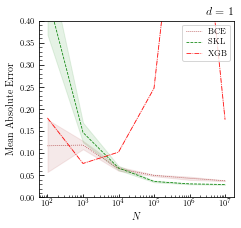

In [23]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/zenodo_d{}.png'.format(d))

### $d = 2$